# Init

In [1]:
import glob
from google.colab import drive
drive.mount('/content/drive')
!pip install navec

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import string
import pickle
import operator
import matplotlib.pyplot as plt
%matplotlib inline
import re
from navec import Navec
import tensorflow as tf
from IPython.display import SVG
from keras.utils import model_to_dot
import matplotlib.pyplot as plt 
import matplotlib.image as img

MAX_LEN = 12
EMBEDDING_DIMENTION = 300
HIDDEN_DIM = 200

In [3]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

Version:  2.4.1
Eager mode:  True
GPU is NOT AVAILABLE
Running on TPU  ['10.97.54.210:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.97.54.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.97.54.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


# Preprocessing text data

In [4]:
import re
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.layers import Input, Dense, LSTM, TimeDistributed
from keras.models import Model
from keras.utils import plot_model
from keras.optimizers import RMSprop

max_question_len = 500
max_answer_len = 500

path = '/content/drive/My Drive/diplom_data/'
file1 = open(path + 'dialogues.txt', 'r') 
# file1 = open(path + 'conversations_ru.txt', 'r') 
lines = file1.readlines()
questions = []
answers = []
for line in lines:
  # print(line)
  question, answer = line.split('%%')
  questions.append(question.strip())
  answers.append(answer.strip())

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    return text

In [6]:
tidy_question = []
for conve in questions:
    text = clean_text(conve)
    tidy_question.append(text)
    
tidy_aswer = []
for conve in answers:
    text = clean_text(conve)
    tidy_aswer.append(text)

In [7]:
start = "<START> "
end = " <END>"
final_target = [start + conve + end for conve in tidy_aswer] 
questions = tidy_question
answers = final_target

# Make vocabulary

In [8]:
tokenizer = Tokenizer(num_words=None, oov_token='unknown')
tokenizer.fit_on_texts(questions + answers) 
vocabulary = list(tokenizer.word_index.items()) # список с cодержимым словаря
vocabulary_size = len(vocabulary) + 1 # размер словаря
print( 'Фрагмент словаря : {}'.format(vocabulary[:100]))
print( 'Размер словаря : {}'.format(vocabulary_size))

Фрагмент словаря : [('unknown', 1), ('start', 2), ('end', 3), ('не', 4), ('я', 5), ('ты', 6), ('и', 7), ('что', 8), ('а', 9), ('вы', 10), ('в', 11), ('нет', 12), ('это', 13), ('как', 14), ('на', 15), ('с', 16), ('мне', 17), ('у', 18), ('меня', 19), ('так', 20), ('же', 21), ('но', 22), ('да', 23), ('тебя', 24), ('все', 25), ('тебе', 26), ('ну', 27), ('мы', 28), ('вас', 29), ('он', 30), ('может', 31), ('знаю', 32), ('почему', 33), ('о', 34), ('бы', 35), ('еще', 36), ('вам', 37), ('за', 38), ('только', 39), ('чем', 40), ('ничего', 41), ('есть', 42), ('к', 43), ('или', 44), ('просто', 45), ('очень', 46), ('если', 47), ('хорошо', 48), ('будет', 49), ('конечно', 50), ('ведь', 51), ('уже', 52), ('быть', 53), ('тоже', 54), ('теперь', 55), ('лучше', 56), ('хочешь', 57), ('для', 58), ('кто', 59), ('надо', 60), ('вот', 61), ('от', 62), ('его', 63), ('тогда', 64), ('чтобы', 65), ('хочу', 66), ('сейчас', 67), ('было', 68), ('разве', 69), ('то', 70), ('нужно', 71), ('раз', 72), ('она', 73), ('по', 7

In [9]:
def prepareDataForNN(phrases, isQuestion = True):
  tokenized_phrases = tokenizer.texts_to_sequences(phrases) 
  max_len_phrases = max([ len(x) for x in tokenized_phrases]) 
  padded_phrases = pad_sequences(tokenized_phrases, maxlen=max_len_phrases, padding='post')
  encoded = np.array(padded_phrases)
  phrase_type = "вопрос"
  if not isQuestion:
    phrase_type = "ответ"    
  print('Пример оригинального ' + phrase_type + 'а на вход : {}'.format(phrases[100])) 
  print('Пример кодированного ' + phrase_type + 'а на вход : {}'.format(encoded[100])) 
  print('Размеры закодированного массива ' + phrase_type + 'ов на вход : {}'.format(encoded.shape)) 
  print('Установленная длина ' + phrase_type + 'ов на вход : {}'.format(max_len_phrases)) 
  return encoded, max_len_phrases

In [10]:
encoder_for_input, max_len_questions = prepareDataForNN(questions, True)
print("======")
decoder_for_input, max_len_answers = prepareDataForNN(answers, False)

Пример оригинального вопроса на вход : какие языки ты знаешь
Пример кодированного вопроса на вход : [210 632   6  89   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Размеры закодированного массива вопросов на вход : (2376, 20)
Установленная длина вопросов на вход : 20
Пример оригинального ответа на вход : <START> я знаю много языков шучу я могу говорить только на русском <END>
Пример кодированного ответа на вход : [   2    5   32  146 1749  797    5   76  151   39   15 1081    3    0
    0    0    0    0    0    0    0    0]
Размеры закодированного массива ответов на вход : (2376, 22)
Установленная длина ответов на вход : 22


# One-hot vectorizer

In [13]:
print("Answers:", len(answers))
tokenized_answers = tokenizer.texts_to_sequences(answers)
print("tokenizedAnswers:", len(tokenized_answers))
for i in range(len(tokenized_answers)): 
  tokenized_answers[i] = tokenized_answers[i][1:] # очистка от тега <START>

padded_answers = pad_sequences(tokenized_answers, maxlen=max_len_answers , padding='post')
print("paddedAnswers:", len(padded_answers))
print("vocabularySize:", vocabulary_size)
one_hot_answers = to_categorical(padded_answers, vocabulary_size) # в one hot vector
decoder_for_output = np.array(one_hot_answers)

Answers: 2376
tokenizedAnswers: 2376
paddedAnswers: 2376
vocabularySize: 5180


# Word2Vec

In [14]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2021-02-02 15:22:07--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar.1’

navec_hudlit_v1_12B 100%[===================>]  50.56M  16.3MB/s    in 3.6s    

2021-02-02 15:22:12 (14.1 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar.1’ saved [53012480/53012480]



In [15]:
navec_path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(navec_path)

In [16]:
def embedding_matrix_creater(embedding_dimention):
    embedding_matrix = np.zeros((len(vocabulary) + 1, embedding_dimention))
    for idx, word in enumerate(vocabulary):
      embedding_vector = navec.get(word[0])
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
            embedding_matrix[idx] = embedding_vector
    return embedding_matrix

In [17]:
embedding_matrix = embedding_matrix_creater(EMBEDDING_DIMENTION)

In [18]:
embed_layer = Embedding(input_dim=vocabulary_size, output_dim=EMBEDDING_DIMENTION, trainable=True,)
embed_layer.build((None,))
embed_layer.set_weights([embedding_matrix])

# Seq2Seq Model

In [19]:
encoder_inputs = Input(shape=(None , ), name = "EncoderForInput")  
encoder_embedding = Embedding(vocabulary_size, EMBEDDING_DIMENTION , mask_zero=True, name = "Encoder_Embedding") (encoder_inputs)
# encoder_embedding = embed_layer(encoder_inputs)
encoder_outputs, state_h , state_c = LSTM(HIDDEN_DIM, return_state=True, name = "Encoder_LSTM")(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, ), name = "DecoderForInput") # размеры на входе сетки (здесь будет decoderForInput)
decoder_embedding = Embedding(vocabulary_size, EMBEDDING_DIMENTION, mask_zero=True, name = "Decoder_Embedding") (decoder_inputs) 
# decoder_embedding =  embed_layer(decoder_inputs)
decoder_LSTM = LSTM(HIDDEN_DIM, return_state=True, return_sequences=True, name = "Decoder_LSTM")
decoder_outputs , _ , _ = decoder_LSTM (decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocabulary_size, activation='softmax') 
output = decoder_dense(decoder_outputs)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderForInput (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderForInput (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
Encoder_Embedding (Embedding)   (None, None, 300)    1554000     EncoderForInput[0][0]            
__________________________________________________________________________________________________
Decoder_Embedding (Embedding)   (None, None, 300)    1554000     DecoderForInput[0][0]            
______________________________________________________________________________________________

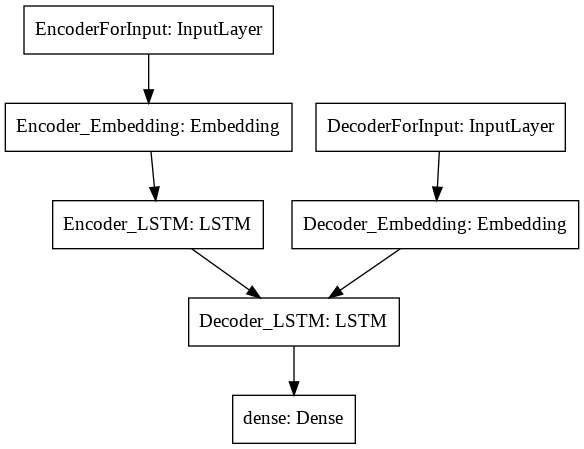

In [20]:
model = Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics = ['accuracy'], sample_weight_mode='temporal')
model.summary()
plot_model(model, to_file='model.png')

# Training model

In [21]:
# model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=50, 
#           callbacks=[MyCallback(), reduce_lr]) 
import time
start_time = time.time()
history = model.fit([encoder_for_input , decoder_for_input], decoder_for_output, batch_size=30, epochs=70)
print("--- %s seconds ---" % (time.time() - start_time))


Epoch 1/70
80/80 [==============================] - 13s 77ms/step - loss: 2.0470 - accuracy: 0.1967
Epoch 2/70
80/80 [==============================] - 6s 77ms/step - loss: 1.5005 - accuracy: 0.3101
Epoch 3/70
80/80 [==============================] - 6s 76ms/step - loss: 1.5089 - accuracy: 0.3047
Epoch 4/70
80/80 [==============================] - 6s 76ms/step - loss: 1.4423 - accuracy: 0.3112
Epoch 5/70
80/80 [==============================] - 6s 77ms/step - loss: 1.3839 - accuracy: 0.3174
Epoch 6/70
80/80 [==============================] - 6s 78ms/step - loss: 1.3877 - accuracy: 0.3175
Epoch 7/70
80/80 [==============================] - 6s 78ms/step - loss: 1.3545 - accuracy: 0.3196
Epoch 8/70
80/80 [==============================] - 6s 77ms/step - loss: 1.2887 - accuracy: 0.3315
Epoch 9/70
80/80 [==============================] - 6s 78ms/step - loss: 1.2665 - accuracy: 0.3364
Epoch 10/70
80/80 [==============================] - 6s 77ms/step - loss: 1.2325 - accuracy: 0.3392
Epoch 11

In [22]:
# save data

with open(path + 'seq2seq/seq2seq_tokenizer.pkl', 'wb') as file:
   pickle.dump(tokenizer, file)

model.save(path + 'seq2seq/seq2seq_training_model.h5')

# Visualize Learning History

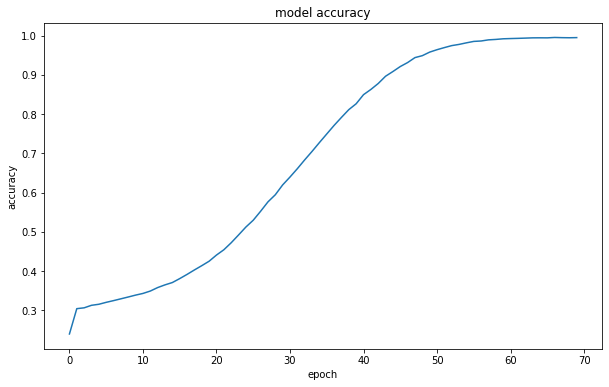

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
#accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

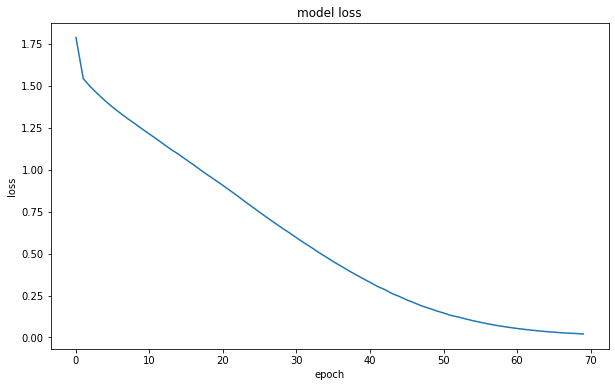

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Chatting

In [25]:
def makeInferenceModels():
    encoder_model = Model(encoder_inputs, encoder_states)
    decoder_state_input_h = Input(shape=(200,), name='decoderStateInput_h')
    decoder_state_input_c = Input(shape=(200,), name='decoderStateInput_c')
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs, state_h, state_c = decoder_LSTM(decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

    return encoder_model, decoder_model

In [26]:
def strToTokens(sentence: str): 
  words = clean_text(sentence).lower().split()
  tokensList = list()
  return pad_sequences(tokenizer.texts_to_sequences([sentence]), maxlen=max_len_questions , padding='post')

In [27]:
enc_model, dec_model = makeInferenceModels()
while True:
    question = input('Задайте вопрос: ')
    if question == 'q' or question == 'й':
        break
    states_values = enc_model.predict(strToTokens(question))

    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition:
        dec_outputs, h, c = dec_model.predict([empty_target_seq] + states_values)

        sampled_word_index = np.argmax(dec_outputs[0, 0, :])
        sampled_word = None
        for word, index in tokenizer.word_index.items():
            if sampled_word == 'end' or len(decoded_translation.split()) > maxLenAnswers:
                stop_condition = True
            if sampled_word_index == index and stop_condition != True:
                decoded_translation += ' {}'.format(word)
                sampled_word = word

        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = sampled_word_index
        states_values = [h, c]

    print(decoded_translation)

Задайте вопрос: q


# Seq2Seq Class

In [28]:
from keras.models import Model

class Seq2SeqModel:
    def __init__(self, model, tokenizer, max_len_questions):
        self._model = model
        self._tokenizer = tokenizer
        self._max_len_questions = max_len_questions
        self._encoder_model, self._decoder_model = self._make_inference_models()

    def _str_to_tokens(self, sentence: str):
        words = self._clean_text(sentence).lower().split()
        return pad_sequences(self._tokenizer.texts_to_sequences([words]), maxlen=self._max_len_questions,
                             padding='post')

    def _clean_text(self, sentence: str):
        sentence = sentence.lower()
        sentence = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", sentence)
        return sentence

    def _make_inference_models(self):
        encoder_inputs = self._model.input[0]
        encoder_embedding = self._model.layers[2](encoder_inputs)
        encoder_outputs, state_h_enc, state_c_enc = self._model.layers[4](encoder_embedding)
        encoder_states = [state_h_enc, state_c_enc]

        encoder_model = Model(encoder_inputs, encoder_states)

        decoder_inputs = self._model.input[1]
        decoder_state_input_h = Input(shape=(200,), name='decoderStateInput_h')
        decoder_state_input_c = Input(shape=(200,), name='decoderStateInput_c')

        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
        decoder_embedding = self._model.layers[3](decoder_inputs)
        decoder_LSTM = self._model.layers[5]
        decoder_outputs, state_h_dec, state_c_dec = decoder_LSTM(decoder_embedding, initial_state=decoder_states_inputs)
        decoder_states = [state_h_dec, state_c_dec]
        decoder_dense = self._model.layers[6]
        decoder_outputs = decoder_dense(decoder_outputs)

        decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

        return encoder_model, decoder_model

    def get_answer(self, sentence: str):
        states_values = self._encoder_model.predict(self._str_to_tokens(sentence))
        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = self._tokenizer.word_index['start']
        stop_condition = False
        decoded_translation = ''
        while not stop_condition:
            dec_outputs, h, c = self._decoder_model.predict([empty_target_seq] + states_values)
            sampled_word_index = np.argmax(dec_outputs[0, 0, :])
            
            word = self._tokenizer.index_word[sampled_word_index]
            if word == 'end' or len(decoded_translation.split()) > 21:
                stop_condition = True
            else:
                decoded_translation += ' {}'.format(word)

            empty_target_seq = np.zeros((1, 1))
            empty_target_seq[0, 0] = sampled_word_index
            states_values = [h, c]
        decoded_translation = decoded_translation.strip().capitalize()
        return decoded_translation


In [29]:
import pickle
from keras.models import load_model

model = load_model(path + 'seq2seq/seq2seq_training_model.h5')

with open(path + 'seq2seq/seq2seq_tokenizer.pkl', 'rb') as file:
  tokenizer = pickle.load(file)


In [30]:
seq2seq = Seq2SeqModel(model, tokenizer, 15)

In [31]:
print(seq2seq.get_answer("Ты милый"))

Я считаю тебя красивой


In [32]:
while True:
  question = input('Задайте вопрос: ')
  if question == 'q' or question == 'й':
    break
  seq2seq.get_answer(question)

Задайте вопрос: ты такой милый


KeyboardInterrupt: ignored